# Intro to Theoretical Neuroscience Homework 4

Salim M'jahad msm2243

## Question 2

### 1

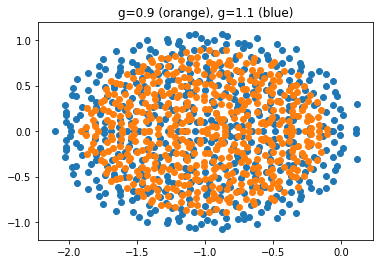

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# dx(t) = -x(t) + W*f(x(t))

def calc_W(N=500, mean=0, g=0.9):
  W = np.random.normal(mean, g/np.sqrt(N), (N,N))
  return W

def get_evals(M):
  evals, _ = np.linalg.eig(M)
  revals = np.array([e.real for e in evals])
  ievals = np.array([e.imag for e in evals])
  return revals, ievals

W = calc_W(g=1.1)
revals, ievals = get_evals(W-np.identity(W.shape[0]))
plt.scatter(revals,ievals)
W = calc_W(g=0.9)
revals, ievals = get_evals(W-np.identity(W.shape[0]))
plt.scatter(revals,ievals)
plt.title('g=0.9 (orange), g=1.1 (blue)')
plt.show()

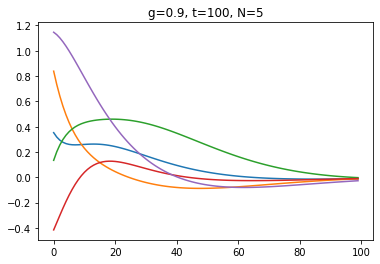

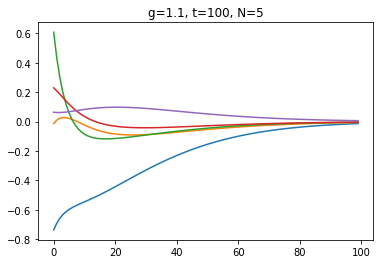

In [0]:
def simulate_linear_network(g, N=5, time_units=100):
  dt = 1e-1
  M = calc_W(g=g, N=N)-np.identity(N)
  res = np.zeros((time_units, N))
  res[0] = np.random.normal(size=N)
  for i in range(1,time_units):
    dx = M.dot(res[i-1])
    res[i] = res[i-1] + dx*dt
  return res 

plt.plot(simulate_linear_network(0.9))
plt.title('g=0.9, t=100, N=5')
plt.show()

plt.plot(simulate_linear_network(1.1))
plt.title('g=1.1, t=100, N=5')
plt.show()

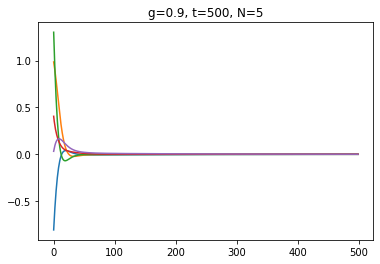

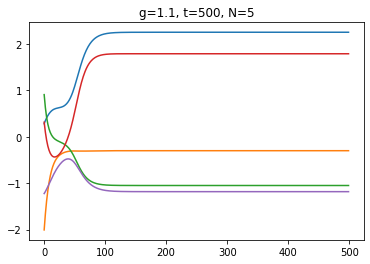

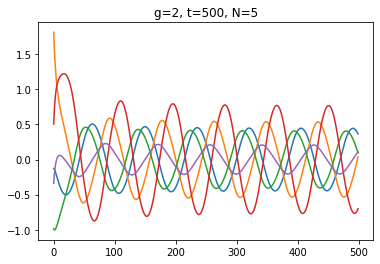

In [0]:
def simulate_nonlinear_network(g, N=5, time_units=500):
  dt = 1e-1
  W = calc_W(g=g, N=N)
  res = np.zeros((time_units, N))
  res[0] = np.random.normal(size=N)
  for i in range(1,time_units):
    dx = -res[i-1] + W.dot(np.tanh(res[i-1]))
    res[i] = res[i-1] + dx*dt
  return res 

plt.plot(simulate_nonlinear_network(0.9))
plt.title('g=0.9, t=500, N=5')
plt.show()

plt.plot(simulate_nonlinear_network(1.1))
plt.title('g=1.1, t=500, N=5')
plt.show()

plt.plot(simulate_nonlinear_network(2.0, N=5))
plt.title('g=2, t=500, N=5')
plt.show()

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter

class FixedPoint(nn.Module):
  def __init__(self, tau=12.5, a=0.7, b=0.8, I=0):
    super(FixedPoint, self).__init__()
    self.tau = tau
    self.a = a
    self.b = b 
    self.I = I
    self.v = Parameter(torch.Tensor(1))
    self.w = Parameter(torch.Tensor(1))
    self.reset_parameters()

  def reset_parameters(self):
    nn.init.uniform_(self.v, a=-2, b=2)
    nn.init.uniform_(self.w, a=-2, b=2)

  def forward(self):
    res = torch.Tensor([0, 0])
    v_term = torch.add(torch.add(torch.add(self.v, torch.div(self.w.pow(3),3.0)),torch.neg(self.w)),self.I)
    w_term = torch.div(torch.add(torch.add(self.v,self.a),torch.neg(torch.mul(self.b,self.w))),self.tau)
    return torch.cat([v_term, w_term])

In [0]:
def run():
  net = FixedPoint().float()
  optimizer =  optim.Adam(net.parameters(), lr=0.01) # play around with that
  criterion = nn.MSELoss()
  losses = []
  optimal_results = []
  for epoch in range(1000):
    optimizer.zero_grad()   # zero the gradient buffers
    output = net()
    loss = criterion(output, torch.Tensor([0,0]).float())
    losses.append(float(loss))
    loss.backward()
    optimizer.step() 
    optimal_results.append([net.v.detach().numpy()[0], net.w.detach().numpy()[0]])
  return losses, optimal_results

Loss: 0.001785819884389639
Run 0, loss 0.001785819884389639, fixed point [0.27381504, 0.2860338]


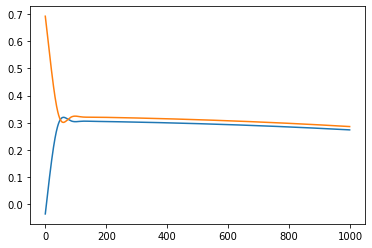

Loss: 0.006856880616396666
Run 1, loss 0.006856880616396666, fixed point [-0.41369483, -1.46986]


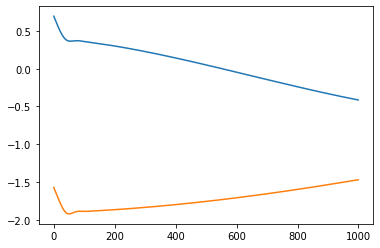

Loss: 0.001420895685441792
Run 2, loss 0.001420895685441792, fixed point [-0.5796846, -0.676894]


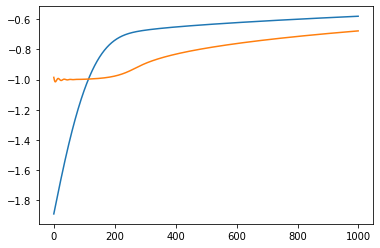

Loss: 2.5988047127611935e-05
Run 3, loss 2.5988047127611935e-05, fixed point [0.39629143, 1.4826757]


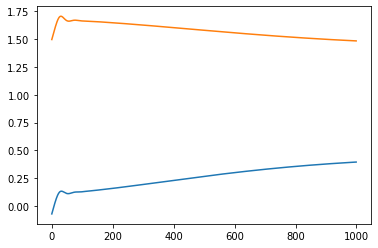

Loss: 0.0016953732119873166
Run 4, loss 0.0016953732119873166, fixed point [0.15175432, 0.15728827]


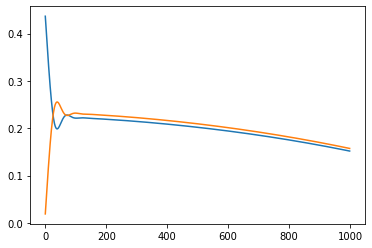

Loss: 0.001621963456273079
Run 5, loss 0.001621963456273079, fixed point [-0.63719815, -0.807352]


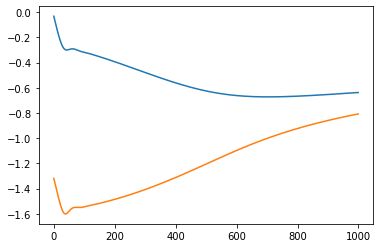

Loss: 0.0012021660804748535
Run 6, loss 0.0012021660804748535, fixed point [0.6581857, 0.93459415]


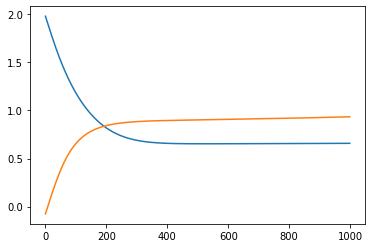

Loss: 0.0005991072976030409
Run 7, loss 0.0005991072976030409, fixed point [0.6447493, 1.1407006]


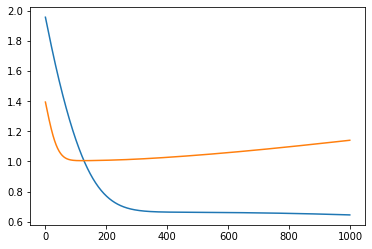

Loss: 0.012432793155312538
Run 8, loss 0.012432793155312538, fixed point [-0.08264803, -1.6900852]


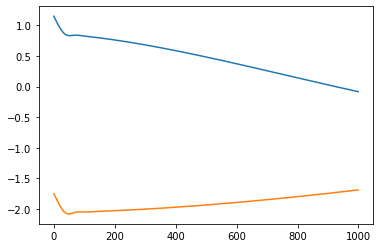

Loss: 0.02089967392385006
Run 9, loss 0.02089967392385006, fixed point [0.34739658, -1.8840748]


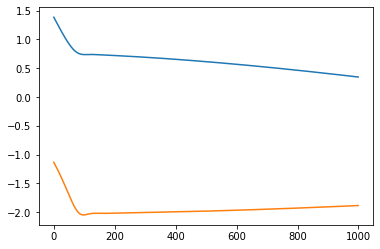

In [0]:
for i in range(10):
  losses, optimal_results = run()
  print('Run {}, loss {}, fixed point {}'.format(i, losses[-1], optimal_results[-1]))
  plt.plot(np.array(optimal_results))
  plt.show()


(500,)


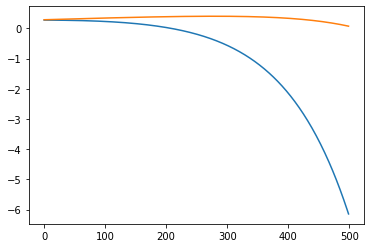

In [0]:
def simulate_FHN(init_v, init_w, time_units=500, tau=12.5, a=0.7, b=0.8, I=0):
  dt= 1e-2
  v = np.zeros(time_units)
  w = np.zeros(time_units)
  v[0] = init_v
  w[0] = init_w
  for i in range(1,time_units):
    dv = v[i-1] + w[i-1]**3/3.0 - w[i-1] + I
    dw = (v[i-1] + a - b*w[i-1])/tau
    v[i] = v[i-1] + dv*dt
    w[i] = w[i-1] + dw*dt
  return v,w

v, w = simulate_FHN(0.27381504, 0.2860338)
print(v.shape)
plt.plot(v)
plt.plot(w)